# 應用場景3:使用 EfficientNet 遷移學習進行狗品種辨識

### 以下程式執行時，請開啟GPU

In [1]:
# IMG_SIZE 的大小和所選擇的EfficientNet有關，本範例使用 EfficientNetB0，其影像輸入大小為224X224
IMG_SIZE = 224

### 載入資料集

In [2]:
import tensorflow as tf               # 載入tensorflow 模組
import tensorflow_datasets as tfds    # 載入tensorflow dataset 模組

batch_size = 64                       # mini-batch 大小為64

dataset_name = "stanford_dogs"        # 所選擇的資料集為 stanford dog dataests

(ds_train, ds_test), ds_info = tfds.load(
    dataset_name, split=["train", "test"], with_info=True, as_supervised=True  # 載入資料集
)
NUM_CLASSES = ds_info.features["label"].num_classes  # 使用 ds_info 取得類別數量


2022-12-26 07:58:05.089600: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "Not found: Could not locate the credentials file.". Retrieving token from GCE failed with "Failed precondition: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling stanford_dogs-train.tfrecord...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling stanford_dogs-test.tfrecord...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


2022-12-26 07:59:29.869711: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-26 07:59:29.986301: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-26 07:59:29.987444: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-26 07:59:29.993361: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [3]:
size = (IMG_SIZE, IMG_SIZE)   # 影像大小設為 224X224
ds_train = ds_train.map(lambda image, label: (tf.image.resize(image, size), label)) # 將訓練資料集影像大小調整成符合網路輸入大小
ds_test = ds_test.map(lambda image, label: (tf.image.resize(image, size), label))   # 將測試資料集影像大小調整成符合網路輸入大小

### 資料視覺化¶

2022-12-26 07:59:33.732636: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


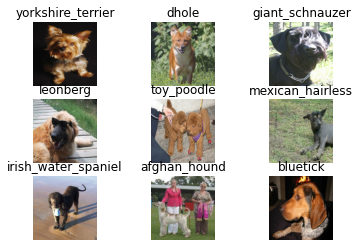

In [4]:
import matplotlib.pyplot as plt # 載入matplotlib模組

# 將label由整數轉成字串
def format_label(label): 
    string_label = label_info.int2str(label)
    return string_label.split("-")[1]

# 顯示圖片內容及標籤
# 挑出9張照片
label_info = ds_info.features["label"]
for i, (image, label) in enumerate(ds_train.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title("{}".format(format_label(label)))
    plt.axis("off")

### 資料擴增¶

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

img_augmentation = Sequential(
    [
        layers.RandomRotation(factor=0.15), # 隨機旋轉
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1), # 隨機平移
        layers.RandomFlip(), # 隨機翻轉
        layers.RandomContrast(factor=0.1), #隨機對比增強
    ],
    name="img_augmentation",
)

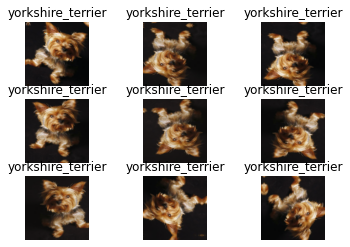

In [6]:
for image, label in ds_train.take(1):
    for i in range(9):  # 隨機產生九張經過 img_augmentation的影像
        ax = plt.subplot(3, 3, i + 1)
        aug_img = img_augmentation(tf.expand_dims(image, axis=0))
        plt.imshow(aug_img[0].numpy().astype("uint8"))
        plt.title("{}".format(format_label(label)))
        plt.axis("off")


### 預備資料輸入¶

In [7]:
#轉成一維向量
#把原來的標簽轉成新的向量
# One-hot / categorical encoding
def input_preprocess(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label


ds_train = ds_train.map(
    input_preprocess, num_parallel_calls=tf.data.AUTOTUNE
)
ds_train = ds_train.batch(batch_size=batch_size, drop_remainder=True)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(input_preprocess)
ds_test = ds_test.batch(batch_size=batch_size, drop_remainder=True)

### 訓練歷程繪圖函式

In [8]:
#hist是物件
import matplotlib.pyplot as plt


def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


### 從預訓練權重進行遷移學習

In [9]:
#x是原來輸入影像大小
#輸入層、影像擴增層
#預訓練權重是imagenet
from tensorflow.keras.applications import EfficientNetB0

def build_model(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = img_augmentation(inputs)
    model = EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    #Dense的類別是NUM_CLASSES，function是softmax
    outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="pred")(x)
    #模型名稱是EfficientNet，正確率是accuracy
    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model


### 鎖定基底模型，只訓練最後一層¶

16719872/16705208 [==============================] - 1s 0us/step
Epoch 1/10


2022-12-26 07:59:45.890416: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005
Cleanup called...


187/187 - 54s - loss: 3.5664 - accuracy: 0.3651 - val_loss: 0.9755 - val_accuracy: 0.7126
Epoch 2/10


Cleanup called...


187/187 - 41s - loss: 1.8519 - accuracy: 0.5241 - val_loss: 0.8141 - val_accuracy: 0.7487
Epoch 3/10


Cleanup called...


187/187 - 40s - loss: 1.5227 - accuracy: 0.5797 - val_loss: 0.7693 - val_accuracy: 0.7596
Epoch 4/10


Cleanup called...


187/187 - 34s - loss: 1.4465 - accuracy: 0.5907 - val_loss: 0.8209 - val_accuracy: 0.7493
Epoch 5/10


Cleanup called...


187/187 - 32s - loss: 1.4037 - accuracy: 0.6046 - val_loss: 0.7907 - val_accuracy: 0.7648
Epoch 6/10


Cleanup called...


187/187 - 32s - loss: 1.3716 - accuracy: 0.6134 - val_loss: 0.8054 - val_accuracy: 0.7622
Epoch 7/10


Cleanup called...


187/187 - 37s - loss: 1.3130 - accuracy: 0.6303 - val_loss: 0.7871 - val_accuracy: 0.7726
Epoch 8/10


Cleanup called...


187/187 - 41s - loss: 1.3154 - accuracy: 0.6272 - val_loss: 0.8297 - val_accuracy: 0.7626
Epoch 9/10


Cleanup called...


187/187 - 32s - loss: 1.2980 - accuracy: 0.6324 - val_loss: 0.8275 - val_accuracy: 0.7591
Epoch 10/10


Cleanup called...


187/187 - 33s - loss: 1.2810 - accuracy: 0.6390 - val_loss: 0.8110 - val_accuracy: 0.7615


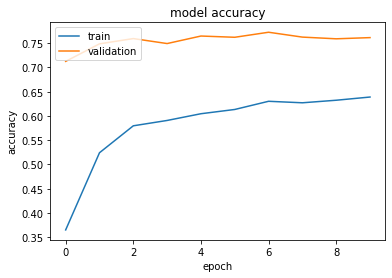

In [10]:
#訓練10回合，可以把這個改成100，看看正確率有多高
model = build_model(num_classes=NUM_CLASSES)

epochs = 10  # @param {type: "slider", min:8, max:80}
hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test, verbose=2)
plot_hist(hist)

  ### 解除基底模型，訓練最後20層¶

Epoch 1/10


Cleanup called...


187/187 - 46s - loss: 1.0119 - accuracy: 0.7039 - val_loss: 0.6999 - val_accuracy: 0.7962
Epoch 2/10


Cleanup called...


187/187 - 41s - loss: 0.8843 - accuracy: 0.7406 - val_loss: 0.6992 - val_accuracy: 0.7957
Epoch 3/10


Cleanup called...


187/187 - 32s - loss: 0.8284 - accuracy: 0.7450 - val_loss: 0.6989 - val_accuracy: 0.7969
Epoch 4/10


Cleanup called...


187/187 - 33s - loss: 0.7838 - accuracy: 0.7599 - val_loss: 0.7125 - val_accuracy: 0.7917
Epoch 5/10


Cleanup called...


187/187 - 40s - loss: 0.7214 - accuracy: 0.7800 - val_loss: 0.6999 - val_accuracy: 0.7943
Epoch 6/10


Cleanup called...


187/187 - 41s - loss: 0.6917 - accuracy: 0.7863 - val_loss: 0.7156 - val_accuracy: 0.7877
Epoch 7/10


Cleanup called...


187/187 - 41s - loss: 0.6768 - accuracy: 0.7940 - val_loss: 0.7138 - val_accuracy: 0.7913
Epoch 8/10


Cleanup called...


187/187 - 40s - loss: 0.6438 - accuracy: 0.8016 - val_loss: 0.7088 - val_accuracy: 0.7933
Epoch 9/10


Cleanup called...


187/187 - 33s - loss: 0.5995 - accuracy: 0.8133 - val_loss: 0.7140 - val_accuracy: 0.7934
Epoch 10/10


Cleanup called...


187/187 - 33s - loss: 0.5689 - accuracy: 0.8246 - val_loss: 0.7187 - val_accuracy: 0.7907


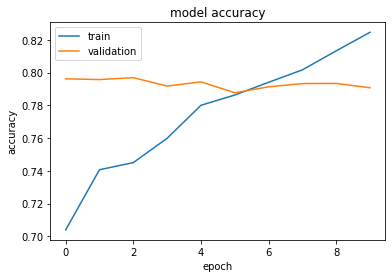

In [11]:
#越接近output是高階的特徵，所以鎖定最後的20層來訓練就好
#-20就是倒數20層
#1e-4是10的4次方
#看到訓練正確率是0.79左右，比剛剛更好一點
#看到圖形上的交叉是出現overfitting，再往下訓練結果也不會更好了
def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )


unfreeze_model(model)

epochs = 10  # @param {type: "slider", min:8, max:50}
hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test, verbose=2)
plot_hist(hist)

### 模型存檔¶

In [12]:
model.save("my-dog-efficientNet")

2022-12-26 08:12:40.649872: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


### 模型載入測試¶

In [13]:
import numpy as np 

reconstructed_model = tf.keras.models.load_model("my-dog-efficientNet")

reconstructed_model.fit(ds_train)



 90/187 [=============>................] - ETA: 11s - loss: 0.5722 - accuracy: 0.8255

Cleanup called...


187/187 [==============================] - 27s 117ms/step - loss: 0.5476 - accuracy: 0.8316


### 壓縮及下載模型供未來使用

### 測試模型

In [14]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input
#在此放上待辨認的圖片，可以用wget
!wget https://upload.wikimedia.org/wikipedia/commons/f/f8/Full_attention_%288067543690%29.jpg -O test.jpg

img_path = 'test.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = reconstructed_model.predict(x)

o = tf.argmax(preds[0])
print(format_label(int(o)))

--2022-12-26 08:13:58--  https://upload.wikimedia.org/wikipedia/commons/f/f8/Full_attention_%288067543690%29.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.154.240, 2620:0:861:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.154.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4906693 (4.7M) [image/jpeg]
Saving to: ‘test.jpg’

test.jpg            100%[===================>]   4.68M  6.66MB/s    in 0.7s    

2022-12-26 08:14:00 (6.66 MB/s) - ‘test.jpg’ saved [4906693/4906693]

standard_poodle
